In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import pylab as plt
import folium
from crime_tool import load_datasets
import scipy
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
%matplotlib inline

In [17]:
ages = ['a70_79','a40_49','a30_39','a10_19','a80_plus','a0_9','a60_69','a50_59','a20_29']

In [6]:
# get cleaned data
df = load_datasets.load_crime_stats(population_group='ages',provence='Western Cape')
# get area and total population
ages = ['a70_79','a40_49','a30_39','a10_19','a80_plus','a0_9','a60_69','a50_59','a20_29']
df['total_age'] = df[ages].sum(1)
df['area'] = df.geometry.area
df['crime_per_pop'] = df.total_crime / df.total_age
df['crime_per_area'] = df.total_crime / df.area
# pivot on crimes
df.head()

,small_area,precinct,a70_79,a40_49,a30_39,a10_19,a80_plus,a0_9,a60_69,a50_59,a20_29,geometry,Province,Crime,Year,total_crime,total_age,area,crime_per_pop,crime_per_area
0,1600049,vanrhynsdorp,18.0,114.0,72.0,84.0,3.0,120.0,36.0,75.0,135.0,"POLYGON ((18.9239346 -31.56851169, 18.9241632 ...",western cape,All theft not mentioned elsewhere,2005,1.0,657.0,0.030518,0.001522,32.768047
1,1600049,vanrhynsdorp,18.0,114.0,72.0,84.0,3.0,120.0,36.0,75.0,135.0,"POLYGON ((18.9239346 -31.56851169, 18.9241632 ...",western cape,All theft not mentioned elsewhere,2006,1.0,657.0,0.030518,0.001522,32.768047
2,1600049,vanrhynsdorp,18.0,114.0,72.0,84.0,3.0,120.0,36.0,75.0,135.0,"POLYGON ((18.9239346 -31.56851169, 18.9241632 ...",western cape,All theft not mentioned elsewhere,2007,1.0,657.0,0.030518,0.001522,32.768047
3,1600049,vanrhynsdorp,18.0,114.0,72.0,84.0,3.0,120.0,36.0,75.0,135.0,"POLYGON ((18.9239346 -31.56851169, 18.9241632 ...",western cape,All theft not mentioned elsewhere,2008,1.0,657.0,0.030518,0.001522,32.768047
4,1600049,vanrhynsdorp,18.0,114.0,72.0,84.0,3.0,120.0,36.0,75.0,135.0,"POLYGON ((18.9239346 -31.56851169, 18.9241632 ...",western cape,All theft not mentioned elsewhere,2009,2.0,657.0,0.030518,0.003044,65.536095


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
df.query('Year == 2017').plot(column='total_crime',ax=ax)

In [ ]:
df.total_crime.hist(bins=range(1,50))
plt.xlabel('Incendence per small area')

# what crimes are increasing?

In [7]:
crime_avg = df.groupby(['Year', 'Crime'])[['crime_per_pop', 'crime_per_area']].mean()
crime_avg = crime_avg.reset_index()
# fil linear model for each crime
slopes = []
for crime in df.Crime.unique():
    temp = crime_avg.query(f'Crime == "{crime}"').groupby('Year').mean().crime_per_pop
    slopes.append(dict(crime = crime, slope = np.polyfit(range(temp.shape[0]), temp,1)[0]))

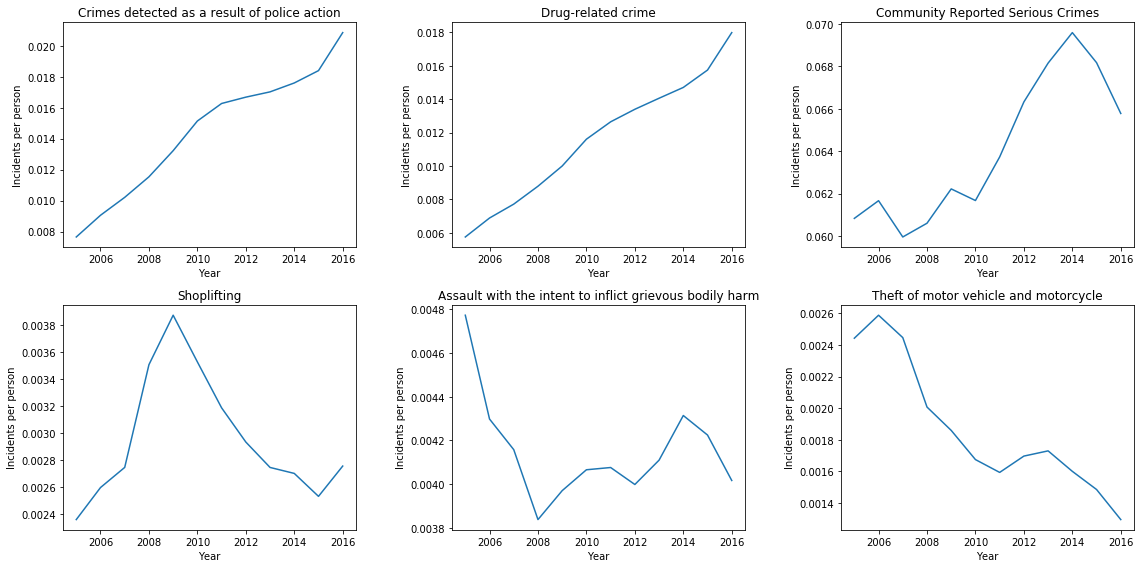

In [8]:
# plot top 3 and bottom 3
slopes = sorted(slopes,key=lambda d: d['slope'],reverse=True)
fig, *ax = plt.subplots(2,3,figsize=(16,8))
ax = ax[0].flatten()
#plot top 3 increasing
for i in range(3):
    crime = slopes[i]['crime']
    temp = crime_avg.query(f'Crime == "{crime}"').groupby('Year').mean().crime_per_pop
    temp.plot(ax=ax[i], label=crime)
    ax[i].set_title(crime)
    ax[i].set_ylabel('Incidents per person')
# plot bottom 3 decreasing
for i in range(-3,0):
    crime = slopes[i]['crime']
    temp = crime_avg.query(f'Crime == "{crime}"').groupby('Year').mean().crime_per_pop
    temp.plot(ax=ax[i], label=crime)
    ax[i].set_title(crime)
    ax[i].set_ylabel('Incidents per person')
plt.tight_layout()

# What crimes are correlated

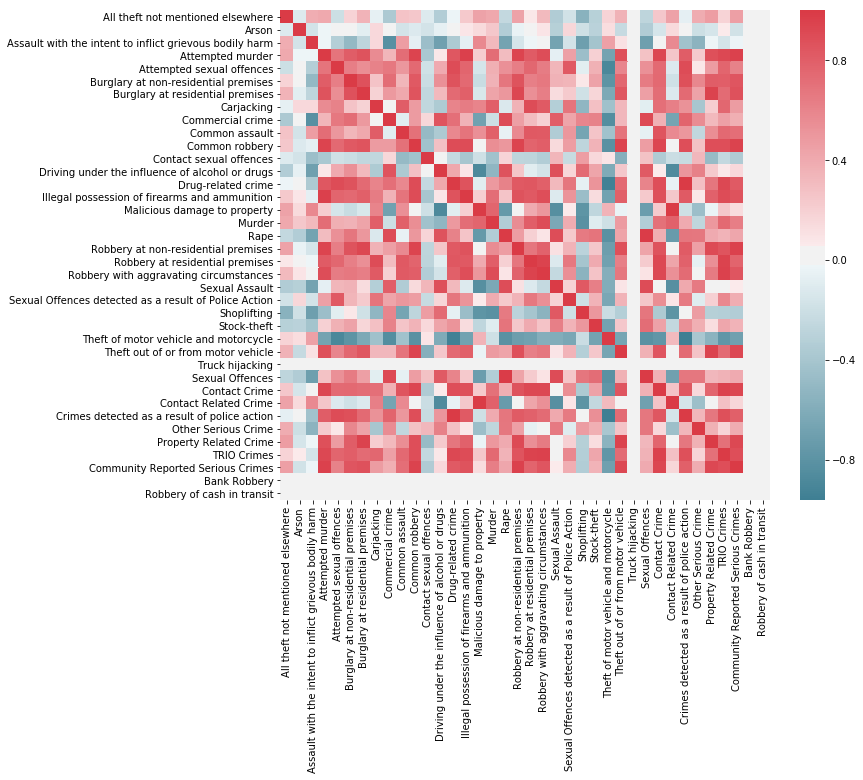

In [9]:
corr_crime = None
for crime in df.Crime.unique():
    # first one makes shape
    if corr_crime is None:
        corr_crime = crime_avg.query(f'Crime == "{crime}"').groupby('Year').mean()[['crime_per_pop']]
        corr_crime = corr_crime.rename(columns={'crime_per_pop':crime})
    else:
        temp = crime_avg.query(f'Crime == "{crime}"').groupby('Year').mean()[['crime_per_pop']]
        temp = temp.rename(columns={'crime_per_pop':crime})
        corr_crime = corr_crime.join(temp)
corr_crime = corr_crime.corr().fillna(0)  

fig, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_crime, cmap=cmap, square=True)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  


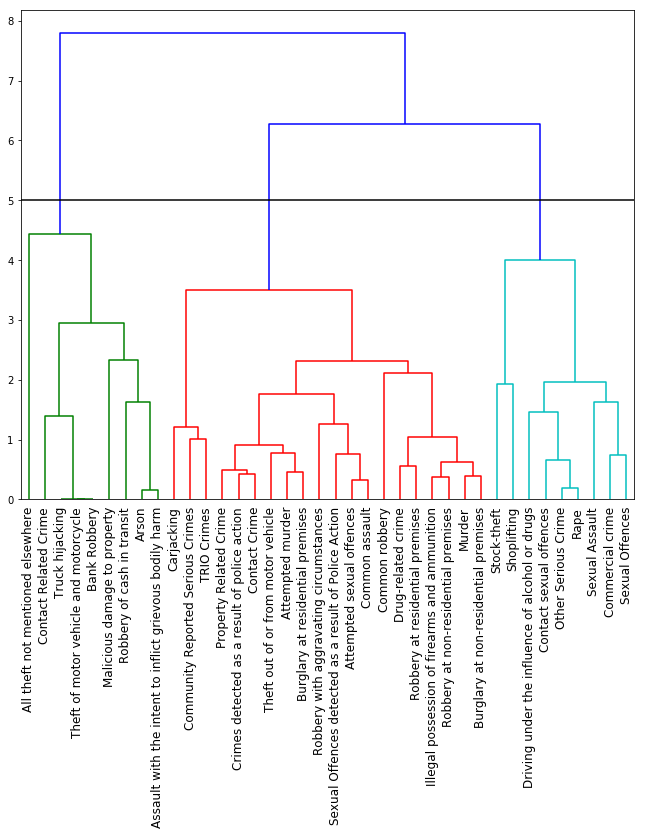

In [11]:
# cluster correlations
d = sch.distance.pdist(corr_crime.values)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 5, 'distance')
labels = [corr_crime.columns.tolist()[i] for i in list((np.argsort(ind)))]
corr_crime = corr_crime.reindex_axis(labels, axis=1)
fig, ax = plt.subplots(figsize=(11, 9))
R = dendrogram(
    L,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=len(labels),  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    ax=ax, no_plot=True)
temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])
dendrogram(
    L,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=len(labels),  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_label_func=llf,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    ax=ax);
ax.hlines(5, ax.get_xlim()[0], ax.get_xlim()[1])


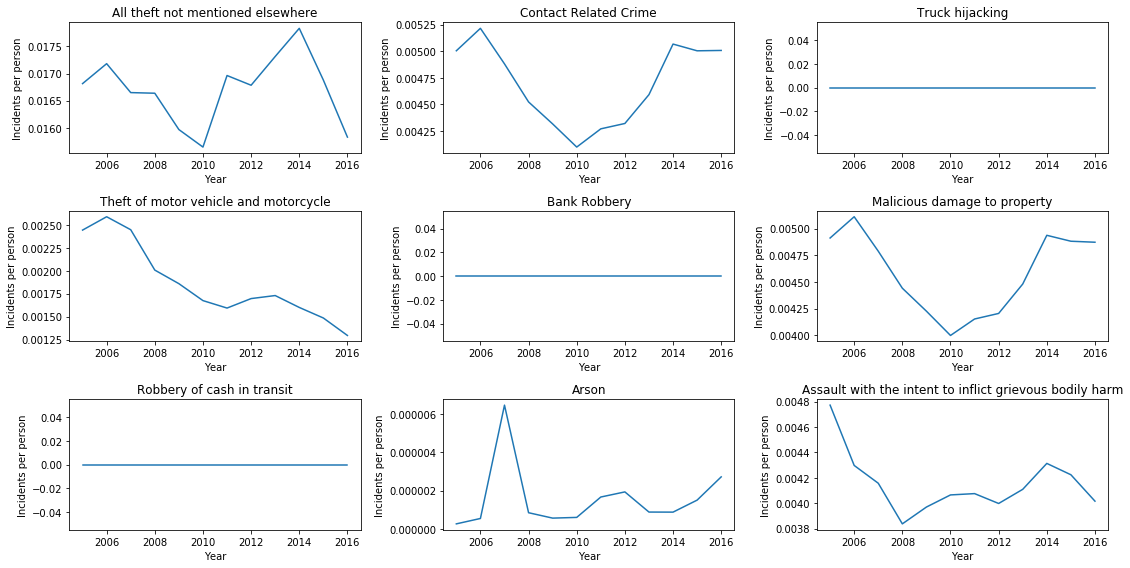

In [13]:
# plot correlated 
crime_list= np.asarray(labels)[np.sort(ind) == 1]
n_plots = len(crime_list)
slopes = sorted(slopes,key=lambda d: d['slope'],reverse=True)
fig, *ax = plt.subplots(np.ceil(n_plots/3).astype(int),3,figsize=(16,8))
ax = ax[0].flatten()
#plot top 3 increasing
for i,crime in enumerate(crime_list):
    temp = crime_avg.query(f'Crime == "{crime}"').groupby('Year').mean().crime_per_pop
    temp.plot(ax=ax[i], label=crime)
    ax[i].set_title(crime)
    ax[i].set_ylabel('Incidents per person')
plt.tight_layout()

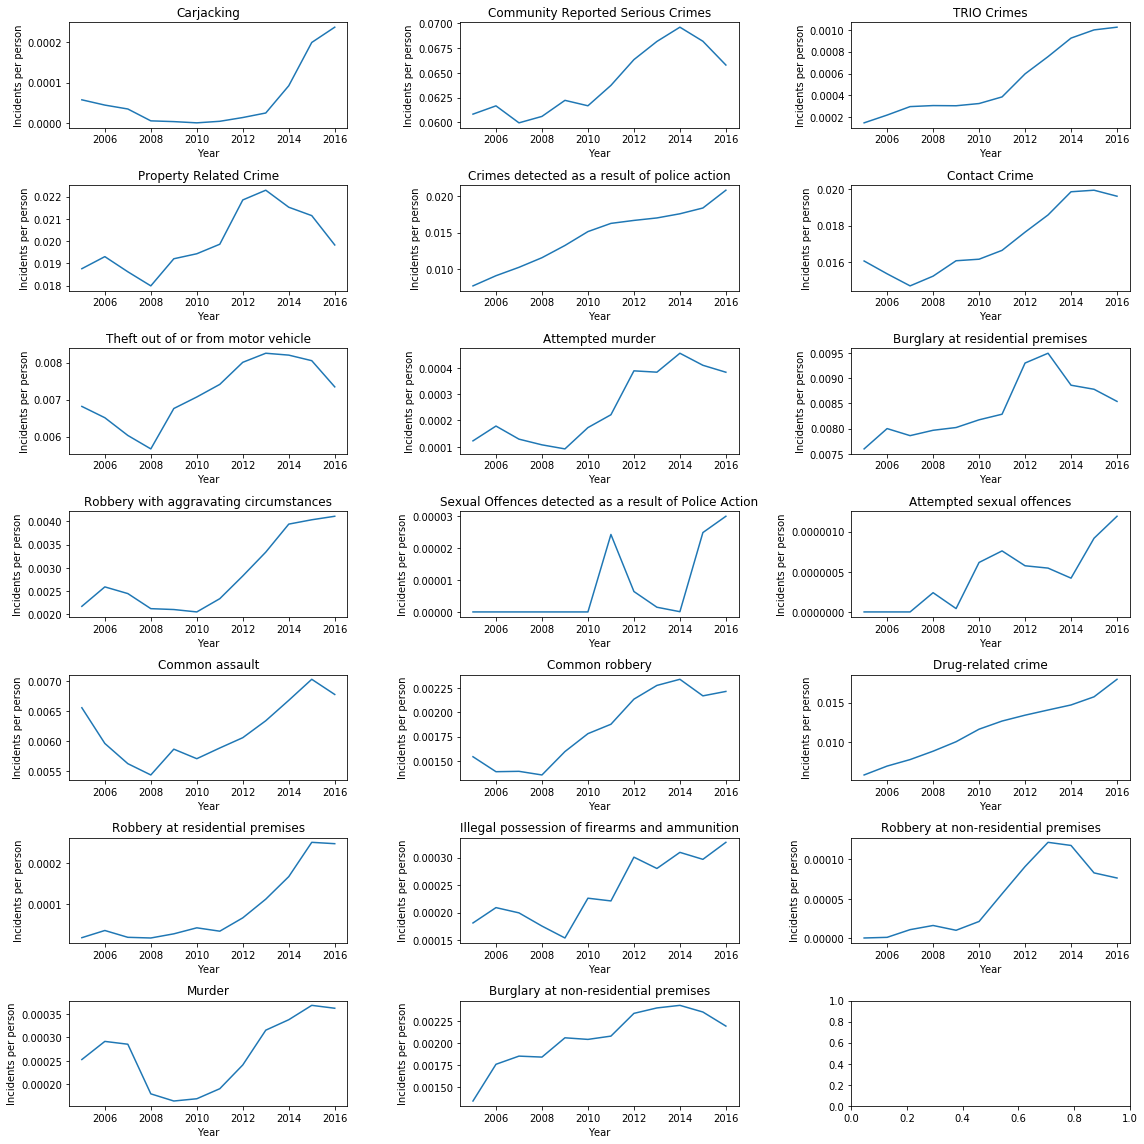

In [14]:
# plot correlated 
crime_list= np.asarray(labels)[np.sort(ind) == 2]
n_plots = len(crime_list)
slopes = sorted(slopes,key=lambda d: d['slope'],reverse=True)
fig, *ax = plt.subplots(np.ceil(n_plots/3).astype(int),3,figsize=(16,16))
ax = ax[0].flatten()
#plot top 3 increasing
for i,crime in enumerate(crime_list):
    temp = crime_avg.query(f'Crime == "{crime}"').groupby('Year').mean().crime_per_pop
    temp.plot(ax=ax[i], label=crime)
    ax[i].set_title(crime)
    ax[i].set_ylabel('Incidents per person')
plt.tight_layout()

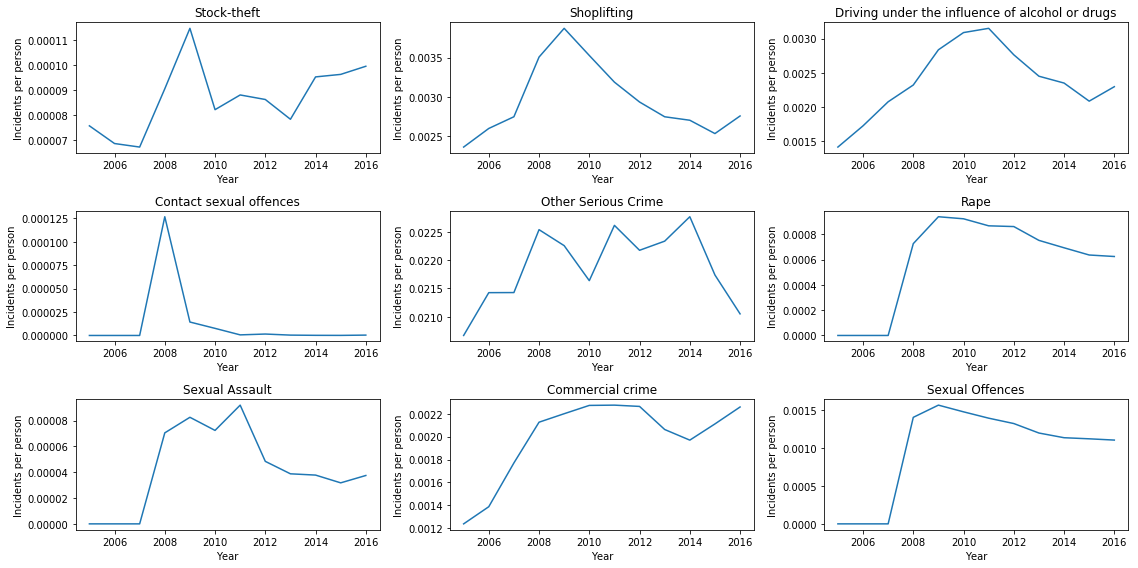

In [15]:
# plot correlated 
crime_list= np.asarray(labels)[np.sort(ind) == 3]
n_plots = len(crime_list)
slopes = sorted(slopes,key=lambda d: d['slope'],reverse=True)
fig, *ax = plt.subplots(np.ceil(n_plots/3).astype(int),3,figsize=(16,8))
ax = ax[0].flatten()
#plot top 3 increasing
for i,crime in enumerate(crime_list):
    temp = crime_avg.query(f'Crime == "{crime}"').groupby('Year').mean().crime_per_pop
    temp.plot(ax=ax[i], label=crime)
    ax[i].set_title(crime)
    ax[i].set_ylabel('Incidents per person')
plt.tight_layout()

# How does crime groups relate to age distrbutions

In [16]:
# make age a ratio
for col in ages:
    df[col] = df[col] / df.total_age

In [25]:
a = df.groupby(['small_area','Crime', 'Year']).mean()
a.head()

a70_79    a40_49  \
small_area Crime                             Year                       
1600001    All theft not mentioned elsewhere 2005  0.020253  0.137975   
                                             2006  0.020253  0.137975   
                                             2007  0.020253  0.137975   
                                             2008  0.020253  0.137975   
                                             2009  0.020253  0.137975   

                                                     a30_39    a10_19  \
small_area Crime                             Year                       
1600001    All theft not mentioned elsewhere 2005  0.129114  0.196203   
                                             2006  0.129114  0.196203   
                                             2007  0.129114  0.196203   
                                             2008  0.129114  0.196203   
                                             2009  0.129114  0.196203   

                                                   a80_plus      a0_9  \
small_area Crime                             Year                       
1600001    All theft not mentioned elsewhere 2005  0.006329  0.217722   
                                             2006  0.006329  0.217722   
                                             2007  0.006329  0.217722   
                                             2008  0.006329  0.217722   
                                             2009  0.006329  0.217722   

                                                    a60_69    a50_59  \
small_area Crime                             Year                      
1600001    All theft not mentioned elsewhere 2005  0.05443  0.074684   
                                             2006  0.05443  0.074684   
                                             2007  0.05443  0.074684   
                                             2008  0.05443  0.074684   
                                             2009  0.05443  0.074684   

                                                     a20_29  total_crime  \
small_area Crime                             Year                          
1600001    All theft not mentioned elsewhere 2005  0.163291         11.0   
                                             2006  0.163291          9.0   
                                             2007  0.163291         16.0   
                                             2008  0.163291         19.0   
                                             2009  0.163291         14.0   

                                                   total_age      area  \
small_area Crime                             Year                        
1600001    All theft not mentioned elsewhere 2005     2370.0  0.003276   
                                             2006     2370.0  0.003276   
                                             2007     2370.0  0.003276   
                                             2008     2370.0  0.003276   
                                             2009     2370.0  0.003276   

                                                   crime_per_pop  \
small_area Crime                             Year                  
1600001    All theft not mentioned elsewhere 2005       0.004641   
                                             2006       0.003797   
                                             2007       0.006751   
                                             2008       0.008017   
                                             2009       0.005907   

                                                   crime_per_area  
small_area Crime                             Year                  
1600001    All theft not mentioned elsewhere 2005     3357.854415  
                                             2006     2747.335431  
                                             2007     4884.151877  
                                             2008     5799.930354  
                                             2009     4273.632892

In [30]:
a.reset_index().head().melt(['small_area','Crime', 'Year'], value_vars=ages,value_name='age_precent' )

,small_area,Crime,Year,variable,age_precent
0,1600001,All theft not mentioned elsewhere,2005,a70_79,0.020253
1,1600001,All theft not mentioned elsewhere,2006,a70_79,0.020253
2,1600001,All theft not mentioned elsewhere,2007,a70_79,0.020253
3,1600001,All theft not mentioned elsewhere,2008,a70_79,0.020253
4,1600001,All theft not mentioned elsewhere,2009,a70_79,0.020253
5,1600001,All theft not mentioned elsewhere,2005,a40_49,0.137975
6,1600001,All theft not mentioned elsewhere,2006,a40_49,0.137975
7,1600001,All theft not mentioned elsewhere,2007,a40_49,0.137975
8,1600001,All theft not mentioned elsewhere,2008,a40_49,0.137975
9,1600001,All theft not mentioned elsewhere,2009,a40_49,0.137975
